Кулаков Ярослав Михайлович BCI.

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.cross_decomposition import PLSRegression
from IPython.display import clear_output
import imageio
import os
import matplotlib
import time 
from sklearn.linear_model import LinearRegression

Загрузка датасета.

In [2]:
X_train = scipy.io.loadmat('ECoG_data/ECoG_X_train.mat')
X_train = X_train['X_train']
X_train.shape

(12801, 32, 27)

In [3]:
X_test = scipy.io.loadmat('ECoG_data/ECoG_X_test.mat')
X_test = X_test['X_hold_out']
X_test.shape

(6087, 32, 27)

In [4]:
y_train = scipy.io.loadmat('ECoG_data/ECoG_Y_train.mat')
y_train = y_train['Y_train']
y_train.shape

(12801, 3)

In [5]:
y_test = scipy.io.loadmat('ECoG_data/ECoG_Y_test.mat')
y_test = y_test['Y_hold_out']
y_test.shape

(6087, 3)

Протестируем на нескольких рядах алгоритм SARIMAX. Сгенерируем 3 функции.

In [279]:
def linear_part(x):
    return (x/70)**2 + np.sin(x/3.2) + 3*np.sin(x/7.3) +  np.exp(-0.07*(x-50)**2 )*10 + random()/8

def spire_part(x):
    return (x/70)**2 + np.sin(x/3.2) + 3*np.sin(x/7.3) +  np.exp(-0.07*(x-98)**2 )*10 + random()/4

def noize_part(x):
    return (x/70)**2 + np.sin(x/3.2) + 3*np.sin(x/7.3) +  np.exp(-0.07*(x-50)**2 )*10 + random()*(x**0.7)/10

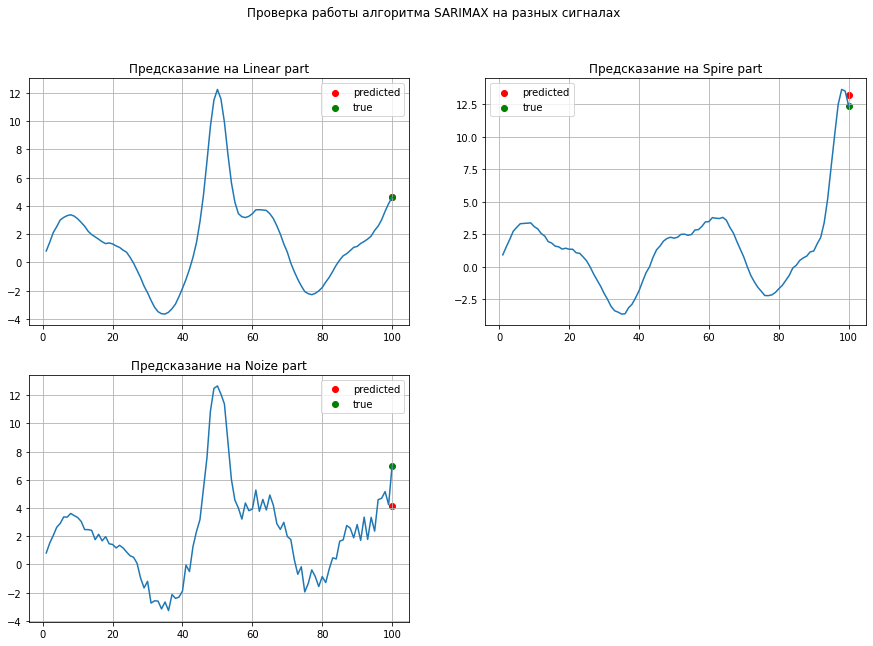

In [297]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset

functions = [linear_part , spire_part, noize_part]
names = ['Linear part', 'Spire part', 'Noize part']


plt.figure(figsize=(15,10))
plt.suptitle("Проверка работы алгоритма SARIMAX на разных сигналах")
for i in range(3):
    data = [functions[i](x) for x in range(1, 100)]
    y_true = functions[i](100)


    # fit model
    model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(data), len(data))

    plt.subplot(2,2,i+1)
    plt.title("Предсказание на " + names[i])
    plt.plot(range(1, 101), data + [y_true])
    plt.scatter([100], [yhat], color='r', label='predicted')
    plt.scatter([100], [y_true], color='g', label='true')
    plt.legend()
    plt.grid()
plt.show()

Можно сделать вывод, что на плавных, близких к линейным участкам сигнала, предсказание алгоритма почти идеальное. Другое дело --- в области резкого изменения сигнала алгоритм справляется не оченьь хорошо. Так же при сильном шуме предсказания получаюся слабыми.

Посмотрим как будет предсказываться координата этим алгоритмом только по прошлым значениям координаты.

In [305]:
predicted_coords = []
for i in range(100,400):
    data = y_train[:i, 0]
    model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=False)
    # make prediction
    predicted_coords.append(model_fit.predict(len(data), len(data)))

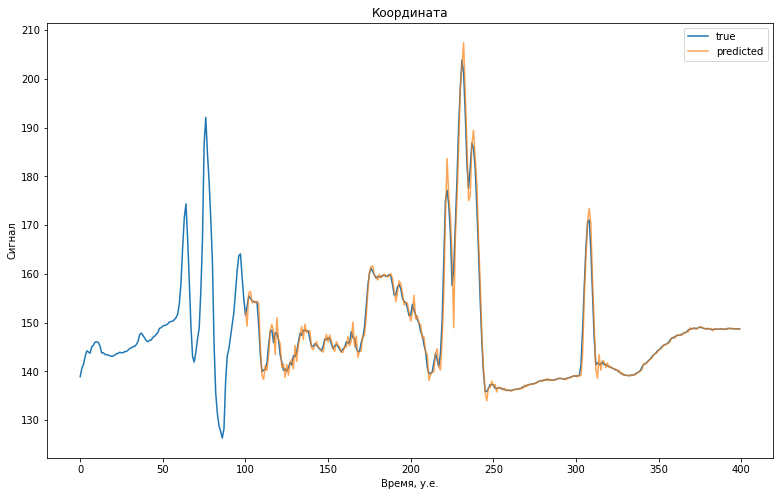

In [311]:
plt.figure(figsize=(13,8))
plt.title("Координата")
plt.plot(np.arange(400), y_train[:400, 0], label='true')
plt.plot(range(100,400), predicted_coords, label='predicted', alpha=0.7)
plt.xlabel("Время, у.е.")
plt.ylabel("Сигнал")
plt.legend()
plt.show()

Обучим PLS. Сгенерируем признаки : экспоненциируем все данные.

In [320]:
pls2 = PLSRegression(n_components=20, max_iter=20000).fit(np.hstack((X_train[:,:, :].reshape((12801, -1)), np.exp(X_train[:,:, :].reshape((12801, -1))))),y_train)

In [321]:
Y_pred = pls2.predict(np.hstack((X_train[:,:, :].reshape((12801, -1)), np.exp(X_train[:,:, :].reshape((12801, -1))))))

In [322]:
def smooth(x, k):
    """
    Для ряда считает среднее по окну длиной к.
    """
    return (np.cumsum(x)[k-1:]  -  np.append([0],np.cumsum(x)[:-k]))/k

In [323]:
ft = [1000, 2000] # верменной диапазон для отрисовки.
k = 7 # размер окна сглаживания

In [392]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

Предскажем координатц по ее прошлым значениям.

In [422]:
predicted_coords = []
for i in tqdm(range(ft[0],ft[1])):
    data = y_train[ft[0]-100:i, 0]
    model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=False)
    # make prediction
    predicted_coords.append(model_fit.predict(i, i))

  1%|          | 8/1000 [00:00<00:45, 21.68it/s]/home/yaroslaw/anaconda3/envs/mipt-stats/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|██████████| 1000/1000 [00:59<00:00, 16.81it/s]


In [424]:
predicted_coords = np.array(predicted_coords)

In [401]:
errors = pd.DataFrame(index=['Clear PLS', 'Clear SARIMAX', 'Mix'], columns=['MSE', 'MAE'])

Построим графики для разных предсказаний.

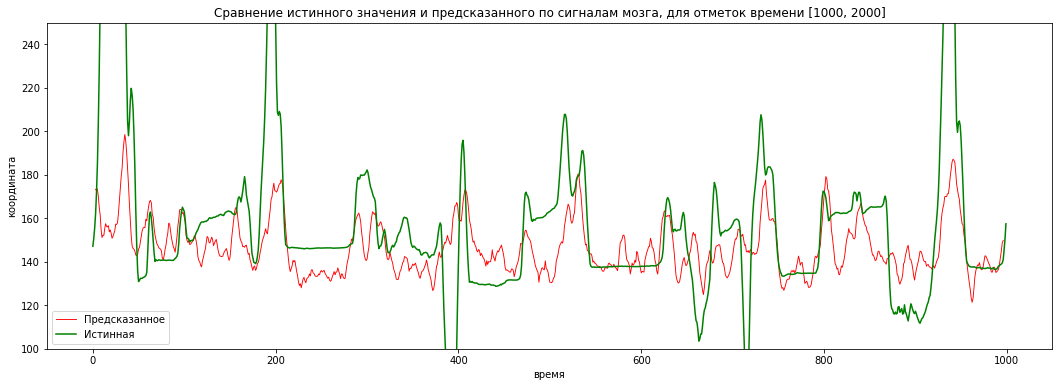

In [376]:
for coord in range(1):
    plt.figure(figsize=(18,6))
    plt.title("Сравнение истинного значения и предсказанного по сигналам мозга, для отметок времени [%d, %d]" % ( ft[0], ft[1]))
    plt.plot(np.arange(k//2,(ft[1]-ft[0]) - k//2), smooth(Y_pred[ft[0]:ft[1],coord], k), c='r', lw=0.9, label="Предсказанное")
    plt.plot(np.arange(ft[1]-ft[0]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.ylim([100, 250])
    plt.show()

In [429]:
errors.loc['Clear PLS', 'MSE'] = mean_squared_error(Y_pred[ft[0] + 50:ft[1],0], y_train[ft[0] + 50:ft[1],0])
errors.loc['Clear PLS', 'MAE'] = mean_absolute_error(Y_pred[ft[0] + 50:ft[1],0], y_train[ft[0] + 50:ft[1],0])

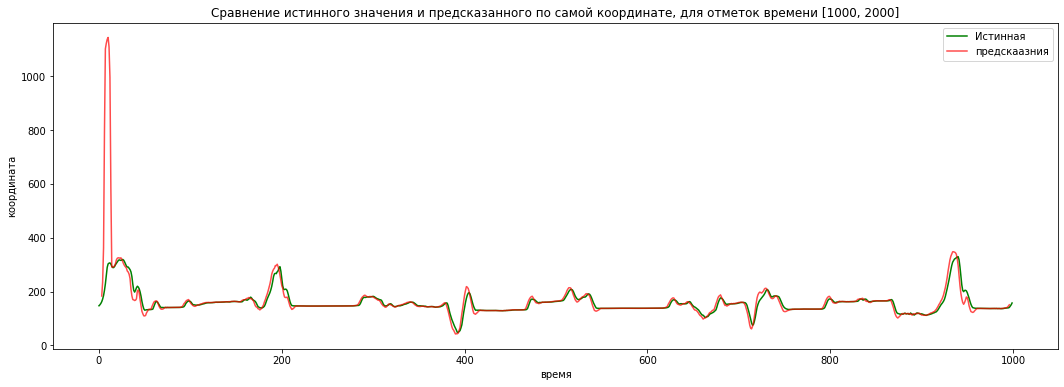

In [425]:
for coord in range(1):
    plt.figure(figsize=(18,6))
    plt.title("Сравнение истинного значения и предсказанного по самой координате, для отметок времени [%d, %d]" % (ft[0], ft[1]))
    plt.plot(np.arange(ft[1]-ft[0]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.plot(np.arange(k//2,(ft[1]-ft[0]) - k//2), smooth(predicted_coords.T[0], k) , label="предскаазния", c='r', alpha=0.7)
    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.show()

In [430]:
errors.loc['Clear SARIMAX', 'MSE'] = mean_squared_error(predicted_coords.T[0][50:], y_train[ft[0] + 50:ft[1],0])
errors.loc['Clear SARIMAX', 'MAE'] = mean_absolute_error(predicted_coords.T[0][50:], y_train[ft[0] + 50:ft[1],0])

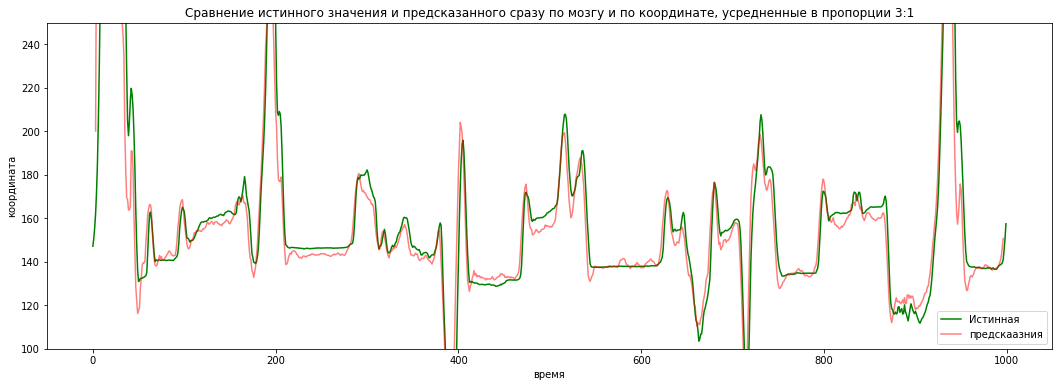

In [389]:
for coord in range(1):
    plt.figure(figsize=(18,6))
    plt.title("Сравнение истинного значения и предсказанного сразу по мозгу и по координате, усредненные в пропорции 3:1")
    plt.plot(np.arange(ft[1]-ft[0]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.plot(np.arange(k//2,(ft[1]-ft[0]) - k//2), (3*smooth(predicted_coords.T[0], k) + smooth(Y_pred[ft[0]:ft[1],coord], k))/4, label="предскаазния", c='r', alpha=0.5)
    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.ylim([100, 250])
    plt.show()

In [431]:
errors.loc['Mix', 'MSE'] = mean_squared_error((3*predicted_coords.T[0][50:] + Y_pred[ft[0] + 50:ft[1], 0])/4, y_train[ft[0] + 50:ft[1],0])
errors.loc['Mix', 'MAE'] = mean_absolute_error((3*predicted_coords.T[0][50:] + Y_pred[ft[0] + 50:ft[1], 0])/4, y_train[ft[0] + 50:ft[1],0])

In [432]:
errors

,MSE,MAE
Clear PLS,840.791,19.0604
Clear SARIMAX,290.792,8.65382
Mix,174.495,7.60459


В ходе эксперемента можно сделать вывод, что чистое предсказанние координаты по сигналам мозга дает неплохие результаты на острых пиках и резких изменениях координыты (то есть при изменении скорости кисти), но плохо и шумно работает, когда кисть покоится, а предсказание координыты по предыдущим ее значениям хорошо работает на слабоизменяющихся участках, таких как покой руки, но ошибается на острых пиках.